### Import Libraries

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer


<div dir="rtl">
    ابزارهای مختلفی وارد می‌شوند که برای پیش‌پردازش داده، تجزیه و تحلیل، آموزش مدل‌ها و ارزیابی آن‌ها استفاده می‌شوند. از این ابزارها برای کار با داده‌ها، عملیات عددی، تصویرسازی داده و مدل‌های مختلف استفاده می‌شود.
</div>


### Data Loading

In [11]:
weather_data = pd.read_csv("BOM.csv")
print(weather_data["RainTomorrow"].isna().sum())

3267


<div dir="rtl">
    داده‌های آب و هوا از فایل "BOM.csv" خوانده می‌شوند و در یک DataFrame ذخیره می‌شوند. تعداد مقادیر گمشده در ستون "RainTomorrow" محاسبه و نمایش داده می‌شود. این مراحل به منظور بررسی اولیه کیفیت داده‌ها و شناسایی تعداد نمونه‌های ناقص در ستون هدف انجام می‌شود.
</div>


In [12]:
weather_data.shape

(145460, 23)

### Data Preprocessing

In [13]:
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

weather_data['Month'] = weather_data['Date'].dt.month
weather_data = weather_data.drop(columns=["Date"])
numeric_columns = list(weather_data.select_dtypes(include=np.number).columns)

for column in numeric_columns:
    median_by_month = weather_data.groupby(['Month'])[column].transform('median')
    weather_data[column] = weather_data[column].fillna(median_by_month)


In [14]:
columns_with_nan = weather_data.columns[weather_data.isna().any()].tolist()
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


<div dir="rtl">
    در این بخش، مراحل پیش‌پردازش داده‌ها انجام می‌شود که شامل تبدیل تاریخ به فرمت datetime، استخراج ماه از تاریخ، حذف ستون تاریخ و جایگزینی مقادیر گمشده با میانه هر ماه می‌شود.
</div>


In [15]:
non_numeric_imputer = SimpleImputer(strategy='most_frequent')

categorical_features = weather_data.select_dtypes(include=['object']).columns.tolist()
weather_data[categorical_features] = non_numeric_imputer.fit_transform(weather_data[categorical_features])

<div dir="rtl">
    مقادیر گمشده در ستون‌های غیرعددی با مقدار پرتکرارترین مقدار در هر ستون جایگزین می‌شوند.
</div>


#### Encoding Categorical Columns

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    weather_data[col] = le.fit_transform(weather_data[col])
    label_encoders[col] = le

### Partitioning the Dataset

In [17]:
train, test = train_test_split(weather_data, test_size=0.3, random_state=42)

print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

Train set shape: (101822, 23)
Test set shape: (43638, 23)


<div dir="rtl">
    داده‌ها به دو مجموعه‌ی آموزشی (train) و آزمایشی (test) تقسیم می‌شوند. 
</div>


### Reducing the Number of Variables

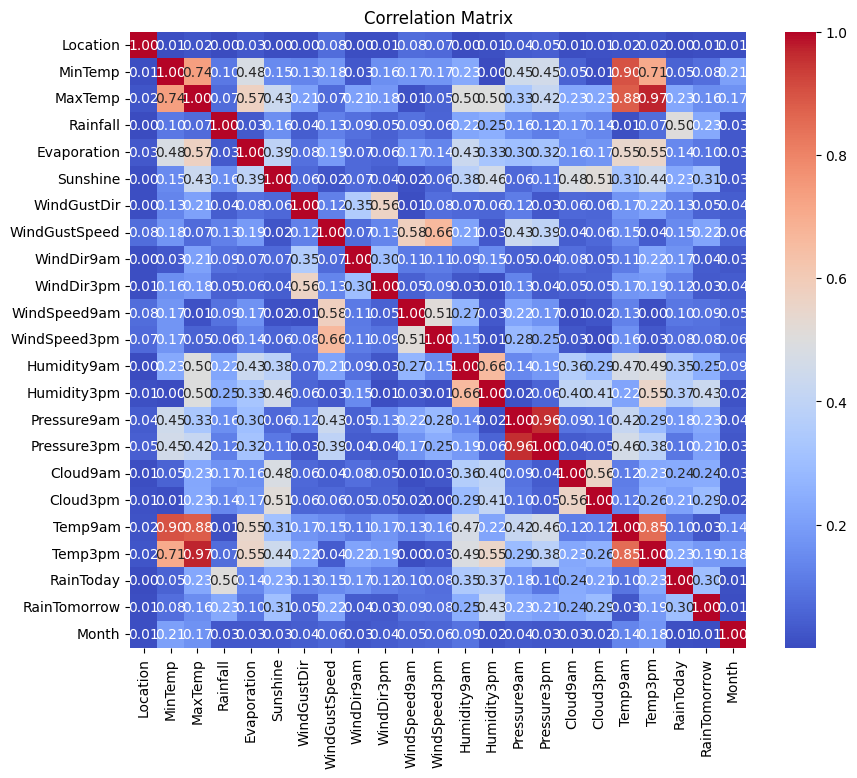

Pairs of highly correlated features:
Index(['Pressure3pm', 'Temp3pm'], dtype='object')
Dropping one of the correlated features: Pressure3pm
Dropping one of the correlated features: Temp3pm
Train set shape after dropping: (101822, 21)
Test set shape after dropping: (43638, 21)


In [18]:
numeric_train = train.select_dtypes(include=np.number)
correlation_matrix = numeric_train.corr().abs()
corr_columns = correlation_matrix.columns


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

correlation_matrix = pd.DataFrame(np.triu(correlation_matrix),columns=corr_columns)
mask = correlation_matrix > 0.95

np.fill_diagonal(mask.values, False)


highly_correlated_features = (mask.sum() > 0)

print("Pairs of highly correlated features:")
print(correlation_matrix.columns[highly_correlated_features])

for feature in correlation_matrix.columns[highly_correlated_features]:
    correlated_features = correlation_matrix.index[mask[feature]].tolist()
    if correlated_features:
        print(f"Dropping one of the correlated features: {feature}")
        numeric_columns.remove(feature)
        train = train.drop(columns=[feature])
        test = test.drop(columns=[feature])


print("Train set shape after dropping:", train.shape)
print("Test set shape after dropping:", test.shape)

<div dir="rtl">
    این قسمت به بررسی همبستگی ویژگی‌ها در مجموعه‌ی آموزشی می‌پردازد و ویژگی‌های با همبستگی بالا را شناسایی و حذف می‌کند. ماتریس همبستگی مطلق (بدون توجه به علامت) محاسبه می‌شود. ویژگی‌هایی که با بیش از 0.95 از ویژگی‌های دیگر همبستگی دارند، شناسایی و یک ویژگی از هر جفت حذف می‌شود.ویژگی‌های حذف شده از هر دو مجموعه‌ی آموزشی و آزمایشی حذف می‌شوند.اگر دو ویژگی دارای همبستگی بسیار بالا باشند، این بدان معناست که اطلاعات مشابهی را ارائه می‌دهند و نگه داشتن هر دو آن‌ها ممکن است موجب پیچیدگی مدل و بیش برازش شود.

در بیشتر موارد منطقی است که یکی از دو ویژگی که دارای همبستگی بالایی هستند را از مجموعه داده‌ها حذف کنیم تا مدل ساده‌تر شود و احتمال بیش برازش کاهش یابد.
</div>


In [19]:
if 'RainTomorrow' in train.columns:
    numeric_columns = train.select_dtypes(include=['number']).columns
    if 'RainTomorrow' in numeric_columns:
        numeric_columns = numeric_columns.drop('RainTomorrow')

    train_features = train[numeric_columns]
    test_features = test[numeric_columns]

    train_target = train['RainTomorrow']

    test_target = test['RainTomorrow']
else:
    print("Error: 'RainTomorrow' column not found in the dataset.")

<div dir="rtl">
    ابتدا بررسی می‌شود که آیا ستون 'RainTomorrow' در داده‌های آموزشی وجود دارد یا خیر. این کار برای اطمینان از وجود ستون هدف انجام می‌شود.
ستون‌های عددی از داده‌ها انتخاب می‌شوند. این ستون‌ها شامل مقادیر عددی هستند که برای مدل‌سازی استفاده می‌شوند.
اگر ستون 'RainTomorrow' در میان ستون‌های عددی باشد، حذف می‌شود تا به عنوان ویژگی ورودی استفاده نشود. داده‌های آموزشی بدون ستون هدف به عنوان ویژگی‌های آموزشی (train_features) و داده‌های آزمایشی بدون ستون هدف به عنوان ویژگی‌های آزمایشی (test_features) ذخیره می‌شوند.
</div>


### Feature Selection using KNN

In [20]:
clf = KNeighborsClassifier()
sfs = SequentialFeatureSelector(clf, n_features_to_select=10, direction='forward', scoring='accuracy')
sfs.fit(train_features, train_target)

selected_features = list(train_features.columns[sfs.support_])
print("Selected features:", selected_features)


Selected features: ['Location', 'MaxTemp', 'Sunshine', 'WindGustSpeed', 'WindDir9am', 'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp9am']


<div dir="rtl">
    فرآیند انتخاب ویژگی‌ها با استفاده از روش انتخاب ویژگی متوالی (Sequential Feature Selection) و مدل KNN (K-Nearest Neighbors) انجام می‌شود.
    </div>


In [21]:
train_selected = train[selected_features + ['RainTomorrow']]
test_selected = test[selected_features + ['RainTomorrow']]

<div dir="rtl">
    داده‌های آموزشی و آزمایشی با استفاده از ویژگی‌های انتخاب شده تغییر شکل می‌یابند که برای استفاده از ویژگی‌هایی که توسط Sequential Feature Selector  انتخاب شده‌اند در مدل‌سازی بعدی انجام می‌شود.
</div>


### Find the Best Value of k

In [22]:
X_train = train_selected[selected_features]
y_train = train_selected['RainTomorrow']

X_test = test_selected[selected_features]
y_test = test_selected['RainTomorrow']

param_grid = {'n_neighbors': range(1, 31, 2)}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

Best k value: 29


<div dir="rtl">
    از GridSearchCV برای جستجوی بهترین مقدار پارامتر k در الگوریتم KNN استفاده می‌شود. این فرآیند شامل مقایسه دقت مدل با مقادیر مختلف برای k است و مقدار بهینه برای k را بر اساس دقت به دست می‌آورد.
</div>


In [23]:
X_train.shape,X_test.shape

((101822, 10), (43638, 10))

### Evaluate the Model on the Test Set

In [24]:
from sklearn.metrics import classification_report

knn_best = KNeighborsClassifier(n_neighbors=27)
knn_best.fit(X_train, y_train)

y_pred = knn_best.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     33987
           1       0.74      0.45      0.56      9651

    accuracy                           0.84     43638
   macro avg       0.80      0.71      0.73     43638
weighted avg       0.83      0.84      0.83     43638



<div dir="rtl">
    مدل KNN با بهترین مقدار پارامتر k که قبلی توسط جستجوی شبکه GridSearchCV مشخص شده است، روی داده‌های آزمون اعمال می‌شود و ارزیابی عملکرد مدل با استفاده از classification_report استفاده می‌شود که شامل معیارهای مختلفی مانند دقت، بازخوانی و اسکور F1 برای هر کلاس موجود در مدل است.
</div>


### Model Testing with Rasht

In [25]:
Rasht_data = pd.read_csv("Rasht.csv")
Rasht_data['Date'] = pd.to_datetime(Rasht_data['Date'])

Rasht_data['Month'] = Rasht_data['Date'].dt.month
Rasht_data = Rasht_data.drop(columns=["Date"])
numeric_columns = list(Rasht_data.select_dtypes(include=np.number).columns)
categorical_features = Rasht_data.select_dtypes(include=['object']).columns.tolist()
Rasht_data[categorical_features] = non_numeric_imputer.fit_transform(Rasht_data[categorical_features])
Rasht_data.shape

(1, 23)

<div dir="rtl">
    در این بخش، داده‌های مربوط به شهر رشت از یک فایل CSV بارگذاری می‌شوند. تاریخ‌ها به فرمت مناسب تبدیل شده و سپس ماه مربوط به هر تاریخ محاسبه می‌شود. ستون تاریخ پس از این مرحله حذف می‌شود و سپس مقادیر عددی و دسته‌ای جداگانه بررسی می‌شوند.
</div>


In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    Rasht_data[col] = le.fit_transform(Rasht_data[col])
    label_encoders[col] = le

In [32]:
test_Rasht = (Rasht_data)
train_selected = train[selected_features + ['RainTomorrow']]
test_selected = test_Rasht[selected_features + ['RainTomorrow']]
X_Rasht = test_selected[selected_features]
y_Rasht = test_selected['RainTomorrow']

<div dir="rtl">
    داده‌های مربوط به شهر رشت به عنوان مجموعه آزمون مشخص شده و سپس مشابه مجموعه داده‌های آموزشی، ویژگی‌های انتخاب شده به همراه ستون باران فردا (RainTomorrow) از مجموعه داده اصلی انتخاب می‌شوند.
</div>

In [33]:
y_pred = knn_best.predict(X_Rasht)

report = classification_report(y_Rasht, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



<div dir="rtl">
    مدل KNN با بهترین پارامترهای پیدا شده قبلی روی داده‌های شهر رشت اعمال می‌شود. سپس از classification_report برای ارزیابی عملکرد مدل استفاده می‌شود تا دقت، بازخوانی و اسکور F1 برای هر کلاس ارزیابی شود و عملکرد کلی مدل بررسی شود. یتاست مربوط به شهر رشت فقط یک سطر داشته باشد، ارزیابی مدل با استفاده از classification_report ممکن است ناپایدار باشد و معیارهای دقت، بازخوانی و اسکور F1 به شکل نادرستی گزارش شوند.
</div>

<div dir="rtl">
 می‌توان با استفاده از همین روش تعیین کرد که آیا فردا بارش خواهد بود یا نه. ابتدا، داده‌هایی که مقدار هدف آن‌ها (یعنی بارش یا عدم بارش) تعیین نشده است را حذف می‌کنیم. از الگوریتم K-NN برای پیش‌بینی وضعیت آب و هوا استفاده می‌کنیم. این الگوریتم بر اساس شباهت داده‌ها در فضای ویژگی‌ها عمل می‌کند و با استفاده از داده‌های آموزش، بهترین مقدار K را با استفاده از مجموعه ارزیابی انتخاب می‌کنیم. در نهایت، با استفاده از همین مدل، وضعیت آب و هوا را برای شهر رشت بر اساس داده‌های مشابه شهرهای دیگر پیش‌بینی می‌کنیم.         مدل می‌تواند احتمال بارش باران را برای یک روز مشخص بر اساس ویژگی‌های ورودی محاسبه کند. این فرآیند این امکان را می‌دهد تا با استفاده از داده‌های قبلی، احتمال بارش باران را پیش‌بینی کنیم.
</div>